In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2026-02-19 13:54:07.854319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771527247.869769   12231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771527247.874388   12231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771527247.885894   12231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771527247.885915   12231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771527247.885917   12231 computation_placer.cc:177] computation placer alr

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.19.1


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Single-step model 

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [10]:
# Values obtained from chapter 15

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [11]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

I0000 00:00:1771527249.577304   12231 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9819 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Epoch 1/50


I0000 00:00:1771527251.675348   12260 service.cc:152] XLA service 0x75a41c0027b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771527251.675369   12260 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2026-02-19 13:54:11.703279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771527251.817952   12260 cuda_dnn.cc:529] Loaded cuDNN version 90300


 76/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1299 - mean_absolute_error: 0.2868

I0000 00:00:1771527252.373795   12260 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0219 - mean_absolute_error: 0.0985 - val_loss: 0.0071 - val_mean_absolute_error: 0.0609
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0552 - val_loss: 0.0042 - val_mean_absolute_error: 0.0489
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0480 - val_loss: 0.0037 - val_mean_absolute_error: 0.0456
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - mean_absolute_error: 0.0442 - val_loss: 0.0028 - val_mean_absolute_error: 0.0388
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0426 - val_loss: 0.0028 - val_mean_absolute_error: 0.0394
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0412 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - mean_absolute_error: 0.0395 - val_loss: 0.

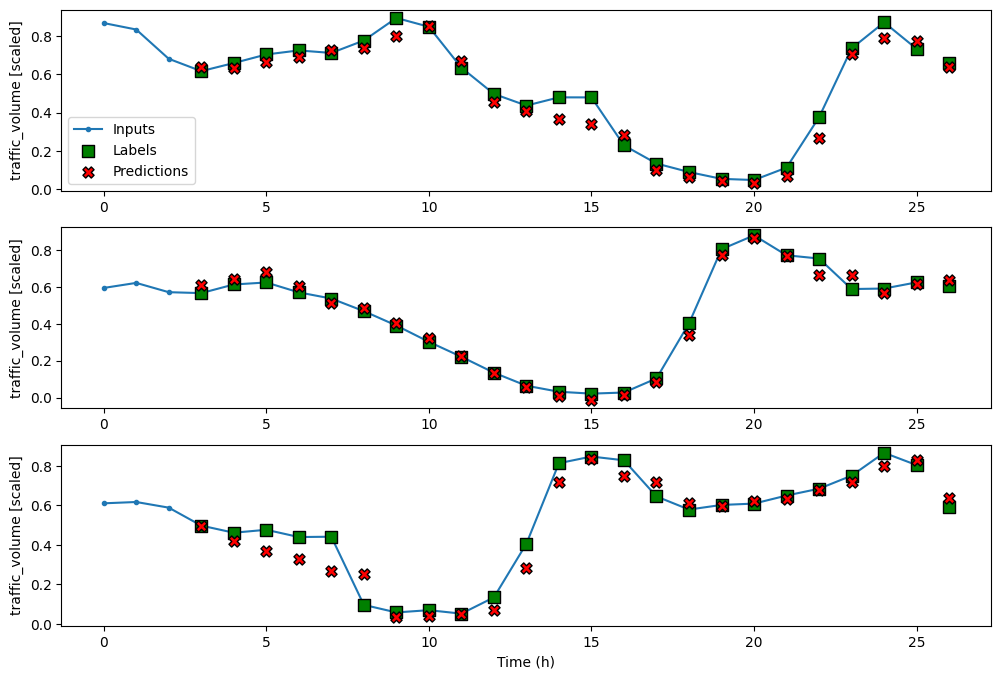

In [12]:
wide_conv_window.plot(cnn_model)

plt.savefig('figures/CH16_F05_peixeiro.png', dpi=300)

#### CNN + LSTM 

In [13]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0341 - mean_absolute_error: 0.1250 - val_loss: 0.0073 - val_mean_absolute_error: 0.0617
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0591 - val_loss: 0.0048 - val_mean_absolute_error: 0.0510
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0526 - val_loss: 0.0038 - val_mean_absolute_error: 0.0468
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0041 - mean_absolute_error: 0.0475 - val_loss: 0.0042 - val_mean_absolute_error: 0.0505
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0444 - val_loss: 0.0033 - val_mean_absolute_error: 0.0444
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0427 - val_loss: 0.0031 - val_mean_absolute_error: 0.0413
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0407 - v

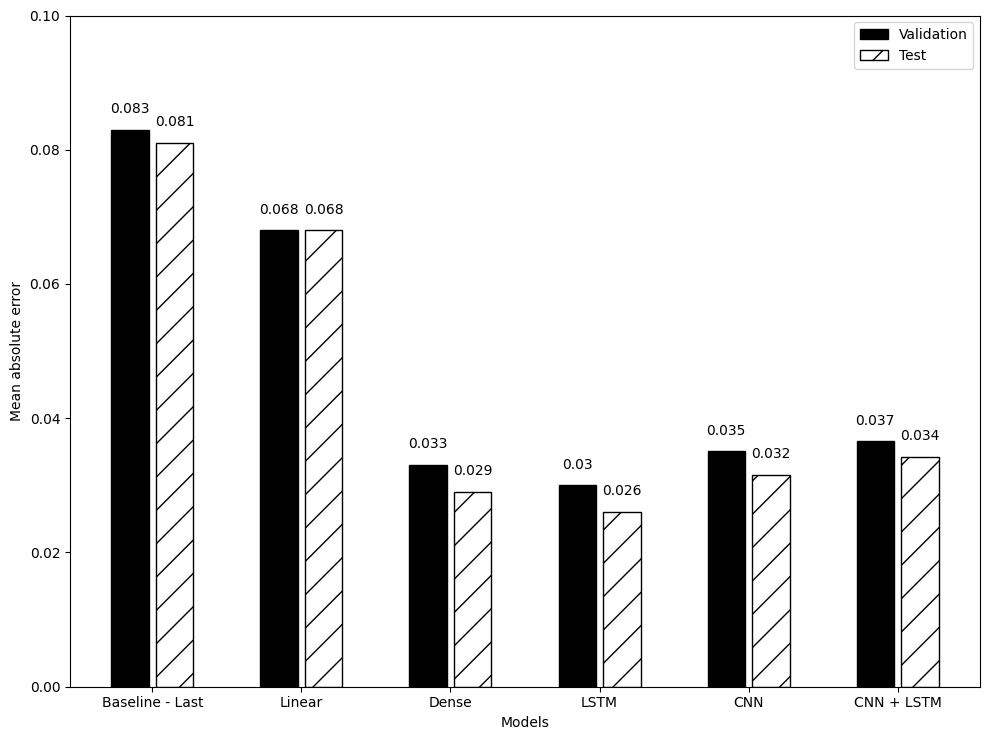

In [14]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F06_peixeiro.png', dpi=300)

### Multi-step model 

In [15]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [16]:
# Values obtained from chapter 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [17]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0321 - mean_absolute_error: 0.1205 - val_loss: 0.0169 - val_mean_absolute_error: 0.0853
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 - mean_absolute_error: 0.0794 - val_loss: 0.0164 - val_mean_absolute_error: 0.0839
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141 - mean_absolute_error: 0.0786 - val_loss: 0.0160 - val_mean_absolute_error: 0.0826
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - mean_absolute_error: 0.0783 - val_loss: 0.0159 - val_mean_absolute_error: 0.0840
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0783 - val_loss: 0.0162 - val_mean_absolute_error: 0.0849
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - mean_absolute_error: 0.0780 - val_loss: 0.0161 - val_mean_absolute_error: 0.0868
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0776 - v

#### CNN + LSTM 

In [18]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0377 - mean_absolute_error: 0.1352 - val_loss: 0.0180 - val_mean_absolute_error: 0.0933
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0148 - mean_absolute_error: 0.0825 - val_loss: 0.0161 - val_mean_absolute_error: 0.0846
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0140 - mean_absolute_error: 0.0786 - val_loss: 0.0157 - val_mean_absolute_error: 0.0822
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0136 - mean_absolute_error: 0.0768 - val_loss: 0.0153 - val_mean_absolute_error: 0.0800
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0131 - mean_absolute_error: 0.0752 - val_loss: 0.0151 - val_mean_absolute_error: 0.0839
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0127 - mean_absolute_error: 0.0741 - val_loss: 0.0148 - val_mean_absolute_error: 0.0765
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0726 - v

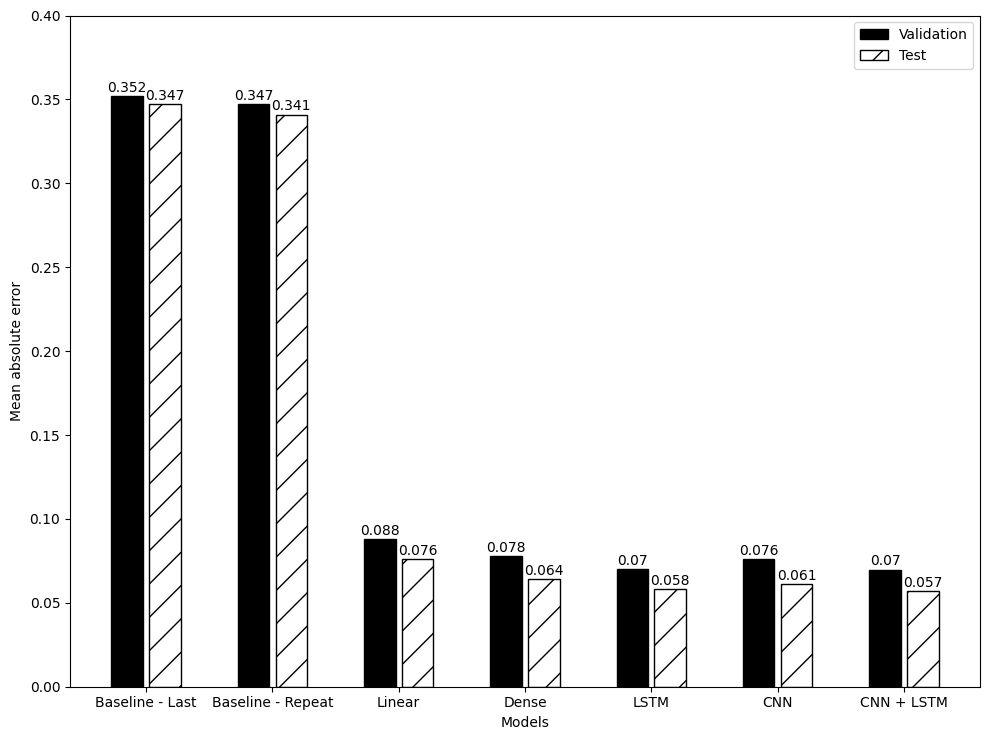

In [19]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F07_peixeiro.png', dpi=300)

### Multi-output model 

In [20]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [21]:
# Values from chapter 15

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [22]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0103 - mean_absolute_error: 0.0608 - val_loss: 0.0027 - val_mean_absolute_error: 0.0353
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0324 - val_loss: 0.0019 - val_mean_absolute_error: 0.0301
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0289 - val_loss: 0.0016 - val_mean_absolute_error: 0.0280
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0274 - val_loss: 0.0014 - val_mean_absolute_error: 0.0256
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0261 - val_loss: 0.0013 - val_mean_absolute_error: 0.0247
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0250 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0241 - v

In [23]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0144 - mean_absolute_error: 0.0738 - val_loss: 0.0031 - val_mean_absolute_error: 0.0374
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0335 - val_loss: 0.0022 - val_mean_absolute_error: 0.0321
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0294 - val_loss: 0.0018 - val_mean_absolute_error: 0.0287
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0275 - val_loss: 0.0015 - val_mean_absolute_error: 0.0257
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0263 - val_loss: 0.0014 - val_mean_absolute_error: 0.0249
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0256 - val_loss: 0.0015 - val_mean_absolute_error: 0.0255
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0246 - v

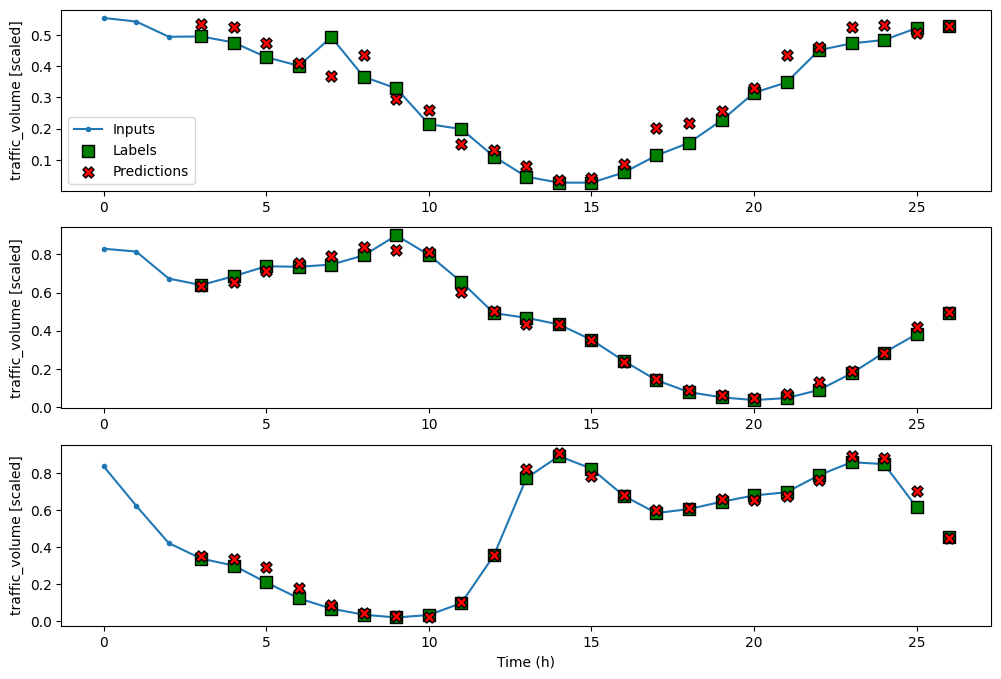

In [24]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

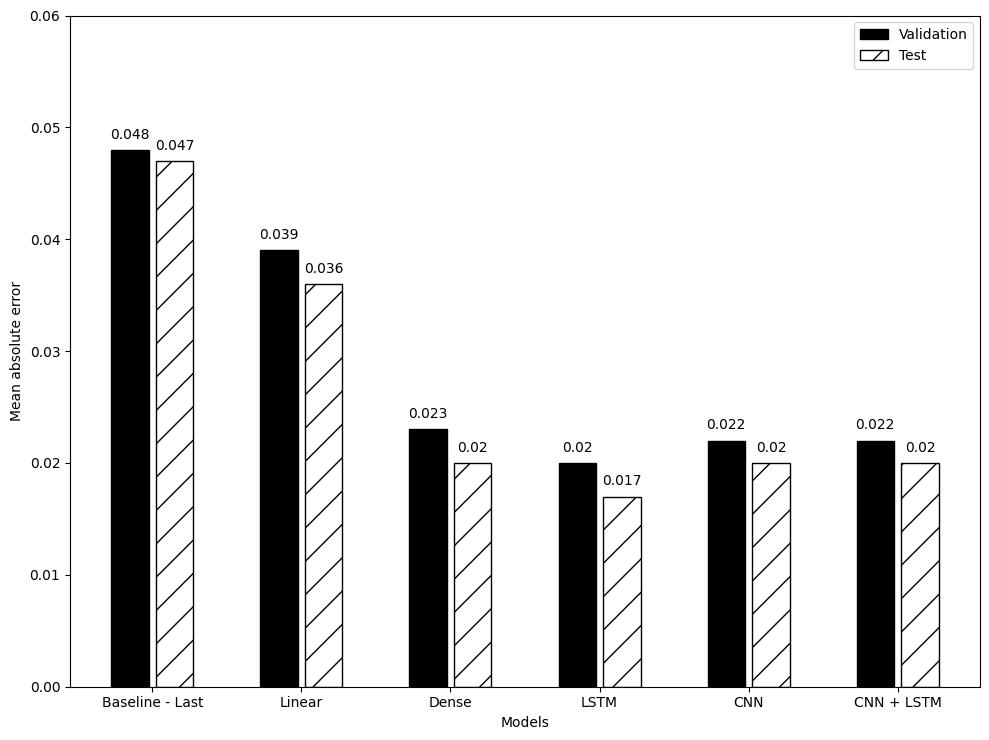

In [25]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F08_peixeiro.png', dpi=300)

Python 3.12, tensorflow 2.19.1, Time elapsed: 4 minutes 7 seconds